# 팀 프로젝트 : 연령별 서울 시민 공공 자전거 이용현황 비교

In [1]:
import pandas as pd
from numpy import nan

In [2]:
# 그래프 그리는 도구 1
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc

In [3]:
# 그래프 그리는 도구 2 : sns.**plot(x='x축컬럼', y='y축컬럼', data=데이터프레임 형태로)
import seaborn as sns
# 단, 한글 표기시 깨지는 문제가 있어서 추가 작업이 필요함.( 한글 폰트 설정에 관한 코드라인 )
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib
import platform

path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")
    
matplotlib.rcParams['axes.unicode_minus'] = False

In [4]:
# 그래프 그리는 도구 3 : 한글 표기가 용이한 대신, 다양한 형태의 그래프를 그리는데 제약이 따름 (ex. 꺽은 선그래프에 평균값, 중앙값, 최대최소 범위 등을 면적으로 나타내는 기능이 없음.)
import plotly
import cufflinks as cf

In [5]:
# 오프라인 환경에서도 작동할 수 있도록
import pandas as pd
import numpy as np  
%matplotlib inline  
from plotly import __version__ 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

## 01) 2018년 데이터셋 불러오기 및 전처리

In [6]:
# 2018년 기본 데이터셋 
bike18 = pd.read_csv('./data_set/서울특별시 공공자전거 이용정보(2018년 전월).csv',encoding='cp949')

# 데이터 전처리(연령대코드)
bike18['연령대코드'].unique()
bike18['연령대코드'].value_counts()
bike18['연령대코드'] = bike18['연령대코드'].map({'~10대':'10대이하','AGE_001':'10대이하',
                                           'AGE_002':'20대', 'AGE_003':'30대',
                                           'AGE_004':'40대', 'AGE_005':'50대',
                                           'AGE_006':'60대', 'AGE_008':'80대이상',
                                           '70대~'  :'70대' , 'AGE_007':'70대'})
bike18['연령대코드'].unique()
bike18['연령대코드'].value_counts()

# 데이터 전처리(성별)
bike18['성별'] = bike18['성별'].fillna('U')
bike18['성별'] = bike18['성별'].str.replace(pat=r' ', repl=r'U', regex=True)
bike18['성별'] = bike18['성별'].map({'m':'M','M':'M',   'f':'F','F':"F",   'U':'Unknown'})
bike18['성별'].unique()

# 주행속력 컬럼 추가하기 : 기존의 컬럼의 값으로 계산하고, 결측치 제거, 이상치 제거
bike18['주행속력'] = ( bike18['이동거리(M)'] / 1000 ) / ( bike18['이동시간(분)'] / 60 )
bike18['주행속력'] = bike18['주행속력'].replace([np.inf, -np.inf], np.nan)

bike18.head()

/Users/works/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (1,7,8) have mixed types.Specify dtype option on import or set low_memory=False.



,대여일자,대여소번호,대여소,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리(M),이동시간(분),주행속력
0,2018_01,108,서교동 사거리,정기,F,10대이하,1,179.94,1.32,5680.0,36,9.466667
1,2018_01,1031,암사동 CBIS,정기,F,10대이하,4,194.39,1.93,8320.0,49,10.187755
2,2018_01,1032,선사고등학교,정기,F,10대이하,1,13.55,0.13,580.0,3,11.600000
3,2018_01,1033,고덕동 아남아파트,정기,F,10대이하,2,58.63,0.55,2390.0,15,9.560000
4,2018_01,1253,오금역 3번 출구 뒤,정기,F,10대이하,3,83.24,0.79,3390.0,26,7.823077


In [7]:
# 2018년 20대 소계 데이터 셋
bike18_sum_age02 = bike18[bike18['연령대코드']=='20대']

bike18_sum_age02 = bike18_sum_age02[['대여일자','이용건수','이동거리(M)','이동시간(분)']].groupby(['대여일자']).sum()
bike18_sum_age02 = pd.DataFrame({'대여일자'    : bike18_sum_age02.index, 
                                 '총 이용건수' : bike18_sum_age02['이용건수'], 
                                 '총 이동거리' : bike18_sum_age02['이동거리(M)'],
                                 '총 이용시간' : bike18_sum_age02['이동시간(분)']})
bike18_sum_age02 = bike18_sum_age02.reset_index(drop=True)
bike18_sum_age02

,대여일자,총 이용건수,총 이동거리,총 이용시간
0,2018_07,521661,2.429009e+09,14275804
1,2018_08,505114,2.334464e+09,13680720
2,2018_09,733453,3.683949e+09,22864581
3,2018_10,693322,3.104524e+09,18300125
4,2018_11,445818,1.666214e+09,9261483
5,2018_12,213234,7.033877e+08,3799188


In [8]:
# 2018년 20대 평균 데이터셋 -> 연령 20대의 데이터는 2018년 7월부터 기록되기시작했다. 2018년 6월 이전의 기록에서는 20대의 이용현황에 대해 알 수 없다.
bike18_mean_age02 = bike18[bike18['연령대코드']=='20대']

bike18_mean_age02 = bike18_mean_age02[['대여일자','이용건수','이동거리(M)','이동시간(분)','주행속력']].groupby(['대여일자']).mean()
bike18_mean_age02 = pd.DataFrame({'대여일자' : bike18_mean_age02.index, 
                                  '평균 이용건수' : bike18_mean_age02['이용건수'], 
                                  '평균 이동거리' : bike18_mean_age02['이동거리(M)'],
                                  '평균 이용시간' : bike18_mean_age02['이동시간(분)'],
                                  '평균 주행속력' : bike18_mean_age02['주행속력']})
bike18_mean_age02 = bike18_mean_age02.reset_index(drop=True)
bike18_mean_age02

,대여일자,평균 이용건수,평균 이동거리,평균 이용시간,평균 주행속력
0,2018_07,56.869181,264799.811403,1556.285185,10.163078
1,2018_08,55.083315,254576.255180,1491.899673,10.337478
2,2018_09,72.893361,366124.906579,2272.369410,10.006232
3,2018_10,67.853005,303828.920532,1790.969368,10.732562
4,2018_11,45.570684,170317.276909,946.691506,11.107743
5,2018_12,23.758663,78371.891922,423.307855,11.388264


## 02) 2019년 데이터셋 불러오기 및 전처리

In [9]:
# 2019년 기본 데이터셋 
bike19 = pd.read_csv('./data_set/서울특별시 공공자전거 이용정보(2019년 전월).csv')

# 데이터 전처리(연령대코드)
bike19['연령대코드'] = bike19['연령대코드'].map({'AGE_001':'10대이하','AGE_002':'20대',
                                            'AGE_003':'30대',  'AGE_004':'40대',
                                            'AGE_005':'50대',  'AGE_006':'60대',
                                            'AGE_007':'70대',  'AGE_008':'80대이상'})

# 데이터 전처리(성별)
bike19['성별'] = bike19['성별'].fillna('U')
bike19['성별'] = bike19['성별'].str.replace(pat=r'\\N', repl=r'U', regex=True)
bike19['성별'] = bike19['성별'].str.replace(pat=r' ', repl=r'U', regex=True)
bike19['성별'] = bike19['성별'].map({'m':'M','M':'M',   'f':'F','F':"F",   'U':'Unknown'})
bike19['성별'].unique()

# 주행속력 컬럼 추가하기 : 기존의 컬럼의 값으로 계산하고, 결측치 제거, 이상치 제거
bike19['주행속력'] = ( bike19['이동거리(M)'] / 1000 ) / ( bike19['이동시간(분)'] / 60 )
bike19['주행속력'] = bike19['주행속력'].replace([np.inf, -np.inf], np.nan)


bike19.head()

,대여일자,대여소번호,대여소,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리(M),이동시간(분),주행속력
0,2019_01,3,중랑센터,일일(회원),M,30대,12,288.87,2.25,9690,117,4.969231
1,2019_01,3,중랑센터,일일(회원),M,40대,8,424.63,3.32,14310,151,5.686093
2,2019_01,3,중랑센터,일일(회원),M,50대,27,4579.48,41.29,177910,542,19.694834
3,2019_01,3,중랑센터,정기,M,30대,17,3438.8,33.58,144730,593,14.643845
4,2019_01,5,상암센터 정비실,일일(회원),M,40대,1,78.31,0.72,3090,33,5.618182


In [10]:
# 2019년 20대 소계 데이터 셋
bike19_sum_age02 = bike19[bike19['연령대코드']=='20대']

bike19_sum_age02 = bike19_sum_age02[['대여일자','이용건수','이동거리(M)','이동시간(분)']].groupby(['대여일자']).sum()
bike19_sum_age02 = pd.DataFrame({'대여일자'    : bike19_sum_age02.index, 
                                 '총 이용건수' : bike19_sum_age02['이용건수'], 
                                 '총 이동거리' : bike19_sum_age02['이동거리(M)'],
                                 '총 이용시간' : bike19_sum_age02['이동시간(분)']})
bike19_sum_age02 = bike19_sum_age02.reset_index(drop=True)
bike19_sum_age02

,대여일자,총 이용건수,총 이동거리,총 이용시간
0,2019_01,201802,691614820,3679159
1,2019_02,201443,788315740,4330084
2,2019_03,421777,1718188060,9567755
3,2019_04,716136,3243287552,19310374
4,2019_05,1100571,5467285170,31170857
5,2019_06,1149248,5988014700,29915544
6,2019_07,1068924,5510300840,25890616
7,2019_08,1041427,5443505970,27113493
8,2019_09,1022525,5630820630,27646405
9,2019_10,1151041,6161908800,28418262


In [11]:
# 2019년 20대 평균 데이터셋
bike19_mean_age02 = bike19[bike19['연령대코드']=='20대']

bike19_mean_age02 = bike19_mean_age02[['대여일자','이용건수','이동거리(M)','이동시간(분)','주행속력']].groupby(['대여일자']).mean()
bike19_mean_age02 = pd.DataFrame({'대여일자' : bike19_mean_age02.index, 
                                  '평균 이용건수' : bike19_mean_age02['이용건수'], 
                                  '평균 이동거리' : bike19_mean_age02['이동거리(M)'],
                                  '평균 이용시간' : bike19_mean_age02['이동시간(분)'],
                                  '평균 주행속력' : bike19_mean_age02['주행속력']})
bike19_mean_age02 = bike19_mean_age02.reset_index(drop=True)
bike19_mean_age02

,대여일자,평균 이용건수,평균 이동거리,평균 이용시간,평균 주행속력
0,2019_01,22.449883,76940.129047,409.295695,13.066209
1,2019_02,21.368728,83623.182349,459.327888,11.583223
2,2019_03,41.161023,167677.179662,933.712794,11.298554
3,2019_04,64.262024,291034.417803,1732.804559,10.294392
4,2019_05,94.122210,467569.072950,2665.770718,10.721522
5,2019_06,76.764946,399974.263576,1998.232850,11.960381
6,2019_07,72.493998,373706.398101,1755.891217,12.728430
7,2019_08,70.686690,369477.090206,1840.323967,12.198673
8,2019_09,69.697021,383806.191125,1884.425397,12.523935
9,2019_10,79.623755,426252.684007,1965.845462,13.763132


In [12]:
# 2019년 30대 소계 데이터 셋
bike19_sum_age03 = bike19[bike19['연령대코드']=='30대']

bike19_sum_age03 = bike19_sum_age03[['대여일자','이용건수','이동거리(M)','이동시간(분)']].groupby(['대여일자']).sum()
bike19_sum_age03 = pd.DataFrame({'대여일자'    : bike19_sum_age03.index, 
                                 '총 이용건수' : bike19_sum_age03['이용건수'], 
                                 '총 이동거리' : bike19_sum_age03['이동거리(M)'],
                                 '총 이용시간' : bike19_sum_age03['이동시간(분)']})
bike19_sum_age03 = bike19_sum_age03.reset_index(drop=True)
bike19_sum_age03

,대여일자,총 이용건수,총 이동거리,총 이용시간
0,2019_01,126778,420613840,2257266
1,2019_02,115852,432389596,2335595
2,2019_03,212208,856384340,4630000
3,2019_04,344435,1569813123,8830362
4,2019_05,478704,2388444040,12883412
5,2019_06,514313,2768522620,13628937
6,2019_07,468794,2447692180,11321376
7,2019_08,449651,2360516520,11719521
8,2019_09,447686,2518756170,12367715
9,2019_10,528647,2941495750,13852973


In [13]:
# 2019년 30대 평균 데이터셋
bike19_mean_age03 = bike19[bike19['연령대코드']=='30대']

bike19_mean_age03 = bike19_mean_age03[['대여일자','이용건수','이동거리(M)','이동시간(분)','주행속력']].groupby(['대여일자']).mean()
bike19_mean_age03 = pd.DataFrame({'대여일자' : bike19_mean_age03.index, 
                                  '평균 이용건수' : bike19_mean_age03['이용건수'], 
                                  '평균 이동거리' : bike19_mean_age03['이동거리(M)'],
                                  '평균 이용시간' : bike19_mean_age03['이동시간(분)'],
                                  '평균 주행속력' : bike19_mean_age03['주행속력']})
bike19_mean_age03 = bike19_mean_age03.reset_index(drop=True)
bike19_mean_age03

,대여일자,평균 이용건수,평균 이동거리,평균 이용시간,평균 주행속력
0,2019_01,16.962537,56276.938721,302.015788,12.363414
1,2019_02,14.556100,54327.126021,293.453323,11.772716
2,2019_03,23.568192,95111.543758,514.215904,11.332084
3,2019_04,34.491789,157201.394252,884.274184,10.633553
4,2019_05,45.962938,229327.320211,1237.005473,11.065429
5,2019_06,39.450257,212358.872440,1045.404388,11.848971
6,2019_07,36.840393,192353.020039,889.695560,12.876685
7,2019_08,35.299969,185312.962789,920.044041,12.834465
8,2019_09,34.820409,195905.434394,961.944077,12.871793
9,2019_10,41.034464,228323.818210,1075.290926,13.280554


In [14]:
# bike18.iloc[:,[0,5]].iplot(kind='bar',x='대여일자' ,theme='space')
# bike18.iloc[:,[0,5]]  =  bike18.loc[:,['대여일자','연령대코드']]  =  bike18.loc[:,'대여일자':'연령대코드':5]

## 03) 2020년 데이터셋 불러오기 및 전처리

In [15]:
# 2020년 기본 데이터 셋
bike20 = pd.read_csv('./data_set/공공자전거 이용정보(2020년 전월).csv',encoding='cp949')

# 데이터 전처리(연령대코드)
bike20['연령대코드'] = bike20['연령대코드'].map({'AGE_001':'10대이하','AGE_002':'20대',
                                            'AGE_003':'30대',  'AGE_004':'40대',
                                            'AGE_005':'50대',  'AGE_006':'60대',
                                            'AGE_007':'70대',  'AGE_008':'80대이상'})

# 데이터 전처리(성별)
bike20['성별'] = bike20['성별'].fillna('U')
bike20['성별'] = bike20['성별'].str.replace(pat=r'\\N', repl=r'U', regex=True)
bike20['성별'] = bike20['성별'].map({'m':'M','M':'M',   'f':'F','F':"F",   'U':'Unknown'})
bike20['성별'].unique()

# 주행속력 컬럼 추가하기 : 기존의 컬럼의 값으로 계산하고, 결측치 제거, 이상치 제거
bike20['주행속력'] = ( bike20['이동거리'] / 1000 ) / ( bike20['이용시간'] / 60 )
bike20['주행속력'] = bike20['주행속력'].replace([np.inf, -np.inf], np.nan)

bike20.head()

,대여일자,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,이용시간,주행속력
0,2020_01,3,중랑센터,일일(회원),M,30대,3,61.82,0.52,2230.0,75,1.784000
1,2020_01,3,중랑센터,일일(회원),M,40대,1,39.62,0.28,1220.0,15,4.880000
2,2020_01,3,중랑센터,정기,M,50대,3,430.85,4.01,17270.0,53,19.550943
3,2020_01,5,상암센터 정비실,일일(회원),Unknown,50대,2,1.79,0.02,90.0,33,0.163636
4,2020_01,5,상암센터 정비실,정기,F,30대,1,4501.96,45.47,196010.0,64,183.759375


In [16]:
# 2020년 20대 소계 데이터 셋
bike20_sum_age02 = bike20[bike20['연령대코드']=='20대']

bike20_sum_age02 = bike20_sum_age02[['대여일자','이용건수','이동거리','이용시간']].groupby(['대여일자']).sum()
bike20_sum_age02 = pd.DataFrame({'대여일자'    : bike20_sum_age02.index, 
                                 '총 이용건수' : bike20_sum_age02['이용건수'], 
                                 '총 이동거리' : bike20_sum_age02['이동거리'],
                                 '총 이용시간' : bike20_sum_age02['이용시간']})
bike20_sum_age02 = bike20_sum_age02.reset_index(drop=True)
bike20_sum_age02

,대여일자,총 이용건수,총 이동거리,총 이용시간
0,2020_01,326277,1.306170e+09,6177108
1,2020_02,317169,1.398153e+09,6915634
2,2020_03,704244,4.180080e+09,24050027
3,2020_04,995677,4.580501e+09,33203710
4,2020_05,1164916,4.420488e+09,39021659
5,2020_06,1278029,8.333574e+09,37861731
6,2020_07,1184603,2.998039e+09,34969389
7,2020_08,786812,5.503126e+08,21358964
8,2020_09,1302676,1.114244e+09,43697421
9,2020_10,1286939,5.501886e+08,35566570


In [17]:
# 2020년 20대 평균 데이터셋
bike20_mean_age02 = bike20[bike20['연령대코드']=='20대']

bike20_mean_age02 = bike20_mean_age02[['대여일자','이용건수','이동거리','이용시간','주행속력']].groupby(['대여일자']).mean()
bike20_mean_age02 = pd.DataFrame({'대여일자'   : bike20_mean_age02.index, 
                                  '평균 이용건수' : bike20_mean_age02['이용건수'], 
                                  '평균 이동거리' : bike20_mean_age02['이동거리'],
                                  '평균 이용시간' : bike20_mean_age02['이용시간'],
                                  '평균 주행속력' : bike20_mean_age02['주행속력']})
bike20_mean_age02 = bike20_mean_age02.reset_index(drop=True)
bike20_mean_age02

,대여일자,평균 이용건수,평균 이동거리,평균 이용시간,평균 주행속력
0,2020_01,26.520117,106166.820288,502.081444,13.419372
1,2020_02,25.274444,111415.477727,551.090445,12.848209
2,2020_03,49.504007,293833.808754,1690.568466,11.387444
3,2020_04,67.867017,312214.652035,2263.220639,8.902060
4,2020_05,73.878488,280345.499120,2474.737380,7.565749
5,2020_06,70.136593,457335.855945,2077.803260,13.823240
6,2020_07,64.140073,162328.177596,1893.409984,4.975151
7,2020_08,44.945276,31435.658333,1220.093911,1.578806
8,2020_09,68.953843,58979.669817,2313.011910,1.553640
9,2020_10,69.365547,29654.969430,1917.025279,1.029069


In [18]:
# 2020년 30대 소계 데이터 셋
bike20_sum_age03 = bike20[bike20['연령대코드']=='30대']

bike20_sum_age03 = bike20_sum_age03[['대여일자','이용건수','이동거리','이용시간']].groupby(['대여일자']).sum()
bike20_sum_age03 = pd.DataFrame({'대여일자'    : bike20_sum_age03.index, 
                                 '총 이용건수' : bike20_sum_age03['이용건수'], 
                                 '총 이동거리' : bike20_sum_age03['이동거리'],
                                 '총 이용시간' : bike20_sum_age03['이용시간']})
bike20_sum_age03 = bike20_sum_age03.reset_index(drop=True)
bike20_sum_age03

,대여일자,총 이용건수,총 이동거리,총 이용시간
0,2020_01,187520,7.685220e+08,3651648
1,2020_02,176534,7.749327e+08,3727529
2,2020_03,333664,1.863423e+09,10381928
3,2020_04,485148,2.110685e+09,16003381
4,2020_05,559575,2.013647e+09,19183104
5,2020_06,642052,4.855228e+09,19824259
6,2020_07,576365,1.467906e+09,17554626
7,2020_08,383188,2.503796e+08,10758373
8,2020_09,623389,5.093593e+08,21056049
9,2020_10,647601,2.794585e+08,19438976


In [19]:
# 2020년 30대 평균 데이터셋
bike20_mean_age03 = bike20[bike20['연령대코드']=='30대']

bike20_mean_age03 = bike20_mean_age03[['대여일자','이용건수','이동거리','이용시간','주행속력']].groupby(['대여일자']).mean()
bike20_mean_age03 = pd.DataFrame({'대여일자'   : bike20_mean_age03.index, 
                                  '평균 이용건수' : bike20_mean_age03['이용건수'], 
                                  '평균 이동거리' : bike20_mean_age03['이동거리'],
                                  '평균 이용시간' : bike20_mean_age03['이용시간'],
                                  '평균 주행속력' : bike20_mean_age03['주행속력']})
bike20_mean_age03 = bike20_mean_age03.reset_index(drop=True)
bike20_mean_age03

,대여일자,평균 이용건수,평균 이동거리,평균 이용시간,평균 주행속력
0,2020_01,18.235923,74737.138967,355.115044,14.578716
1,2020_02,17.243016,75691.808947,364.087615,13.383338
2,2020_03,27.149227,151621.060960,844.745972,11.374633
3,2020_04,37.119204,161490.818669,1224.436190,8.574749
4,2020_05,39.867127,143463.057875,1366.707324,6.360226
5,2020_06,40.048154,302846.074855,1236.543101,16.381645
6,2020_07,35.529836,90488.570742,1082.149303,4.889210
7,2020_08,25.163383,16442.056327,706.486275,1.683060
8,2020_09,37.203927,30398.618759,1256.627417,1.557517
9,2020_10,38.906639,16789.334484,1167.856774,0.877112


## 04) 2021년 데이터셋 불러오기 및 전처리

In [20]:
# 2021년 기본 데이터 셋
bike21 = pd.read_csv('./data_set/공공자전거 이용정보(2021년 전월).csv',encoding='cp949')

# 데이터 전처리(연령대코드)
bike21['연령대코드'] = bike21['연령대코드'].map({'AGE_001':'10대이하','AGE_002':'20대',
                                            'AGE_003':'30대',  'AGE_004':'40대',
                                            'AGE_005':'50대',  'AGE_006':'60대',
                                            'AGE_007':'70대',  'AGE_008':'80대이상'})

# 데이터 전처리(성별)
bike21['성별'] = bike21['성별'].fillna('U')
bike21['성별'] = bike21['성별'].str.replace(pat=r'\\N', repl=r'U', regex=True)
bike21['성별'] = bike21['성별'].map({'m':'M','M':'M',   'f':'F','F':"F",   'U':'Unknown'})
bike21['성별'].unique()

# 주행속력 컬럼 추가하기 : 기존의 컬럼의 값으로 계산하고, 결측치 제거, 이상치 제거
bike21['주행속력'] = ( bike21['이동거리'] / 1000 ) / ( bike21['이용시간'] / 60 )
bike21['주행속력'] = bike21['주행속력'].replace([np.inf, -np.inf], np.nan)

bike21.head()

,대여일자,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,이용시간,주행속력
0,2021_01,3,중랑센터,일일(회원),M,30대,2,47.68,0.4,1720.00,25,4.128000
1,2021_01,3,중랑센터,정기,M,30대,11,578.98,2.87,12390.48,166,4.478487
2,2021_01,3,중랑센터,정기,M,40대,1,81.65,0.53,2291.05,13,10.574077
3,2021_01,5,상암센터 정비실,일일(회원),Unknown,40대,1,511.95,3.53,15209.58,47,19.416485
4,2021_01,5,상암센터 정비실,일일(회원),M,40대,6,371.1,3.39,14642.60,134,6.556388


In [21]:
# 2021년 20대 소계 데이터 셋
bike21_sum_age02 = bike21[bike20['연령대코드']=='20대']

bike21_sum_age02 = bike21_sum_age02[['대여일자','이용건수','이동거리','이용시간']].groupby(['대여일자']).sum()
bike21_sum_age02 = pd.DataFrame({'대여일자'    : bike21_sum_age02.index, 
                                 '총 이용건수' : bike21_sum_age02['이용건수'], 
                                 '총 이동거리' : bike21_sum_age02['이동거리'],
                                 '총 이용시간' : bike21_sum_age02['이용시간']})
bike21_sum_age02 = bike21_sum_age02.reset_index(drop=True)
bike21_sum_age02

<ipython-input-21-73569fa3524b>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,대여일자,총 이용건수,총 이동거리,총 이용시간
0,2021_01,182609,5.088768e+08,4677822
1,2021_02,267360,8.964171e+08,7787758
2,2021_03,447523,1.394143e+09,11995223
3,2021_04,608071,1.969062e+09,17324014
4,2021_05,610881,1.978192e+09,17078800
5,2021_06,698186,2.118477e+09,18050900


In [22]:
# 2021년 20대 평균 데이터셋
bike21_mean_age02 = bike21[bike20['연령대코드']=='20대']

bike21_mean_age02 = bike21_mean_age02[['대여일자','이용건수','이동거리','이용시간','주행속력']].groupby(['대여일자']).mean()
bike21_mean_age02 = pd.DataFrame({'대여일자'   : bike21_mean_age02.index, 
                                  '평균 이용건수' : bike21_mean_age02['이용건수'], 
                                  '평균 이동거리' : bike21_mean_age02['이동거리'],
                                  '평균 이용시간' : bike21_mean_age02['이용시간'],
                                  '평균 주행속력' : bike21_mean_age02['주행속력']})
bike21_mean_age02 = bike21_mean_age02.reset_index(drop=True)
bike21_mean_age02

<ipython-input-22-6f9d7fbaddf7>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,대여일자,평균 이용건수,평균 이동거리,평균 이용시간,평균 주행속력
0,2021_01,11.552413,32193.129193,295.933574,6.691908
1,2021_02,14.168521,47504.882275,412.705776,7.102262
2,2021_03,22.151314,69006.725383,593.734742,6.902837
3,2021_04,26.251824,85008.941021,747.917541,6.765084
4,2021_05,25.557736,82762.622868,714.534349,6.914267
5,2021_06,28.430084,86264.229914,735.031354,7.071820


In [23]:
# 2021년 30대 소계 데이터 셋
bike21_sum_age03 = bike21[bike21['연령대코드']=='30대']

bike21_sum_age03 = bike21_sum_age03[['대여일자','이용건수','이동거리','이용시간']].groupby(['대여일자']).sum()
bike21_sum_age03 = pd.DataFrame({'대여일자'    : bike21_sum_age03.index, 
                                 '총 이용건수' : bike21_sum_age03['이용건수'], 
                                 '총 이동거리' : bike21_sum_age03['이동거리'],
                                 '총 이용시간' : bike21_sum_age03['이용시간']})
bike21_sum_age03 = bike21_sum_age03.reset_index(drop=True)
bike21_sum_age03

,대여일자,총 이용건수,총 이동거리,총 이용시간
0,2021_01,197968,5.073749e+08,4771705
1,2021_02,294533,9.181616e+08,7907155
2,2021_03,520888,1.572533e+09,13364045
3,2021_04,710608,2.234474e+09,19254613
4,2021_05,648726,2.067907e+09,17431094
5,2021_06,746743,2.226647e+09,18708576


In [24]:
# 2021년 30대 평균 데이터셋
bike21_mean_age03 = bike21[bike21['연령대코드']=='30대']

bike21_mean_age03 = bike21_mean_age03[['대여일자','이용건수','이동거리','이용시간','주행속력']].groupby(['대여일자']).mean()
bike21_mean_age03 = pd.DataFrame({'대여일자'   : bike21_mean_age03.index, 
                                  '평균 이용건수' : bike21_mean_age03['이용건수'], 
                                  '평균 이동거리' : bike21_mean_age03['이동거리'],
                                  '평균 이용시간' : bike21_mean_age03['이용시간'],
                                  '평균 주행속력' : bike21_mean_age03['주행속력']})
bike21_mean_age03 = bike21_mean_age03.reset_index(drop=True)
bike21_mean_age03

,대여일자,평균 이용건수,평균 이동거리,평균 이용시간,평균 주행속력
0,2021_01,14.648021,37541.616163,353.067333,6.687317
1,2021_02,18.404862,57374.342100,494.104543,7.239817
2,2021_03,30.150961,91024.128468,773.561299,7.071739
3,2021_04,37.582399,118176.127426,1018.331553,6.959293
4,2021_05,33.647614,107256.590169,904.102386,7.132618
5,2021_06,38.093302,113587.056666,954.373106,7.217619


## 05) 2018년,2019년,2020년,2021년 연령대별 총 이용건수

<AxesSubplot:xlabel='연령대코드', ylabel='count'>

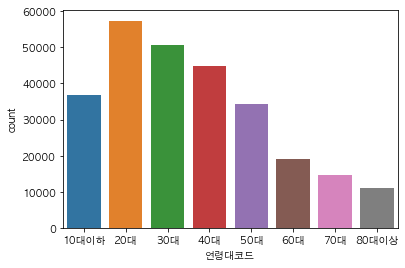

In [25]:
bike18 = bike18.sort_values(by='연령대코드', ascending=True)
sns.countplot(x='연령대코드', data=bike18)

In [62]:
bike18_total_age = bike18[['이용건수','연령대코드']].groupby(['연령대코드']).sum()
bike18_total_age = pd.DataFrame({'연령대' : bike18_total_age.index,
                                 '이용건수' : bike18_total_age['이용건수']})
bike18_total_age = bike18_total_age.reset_index(drop=True)
bike18_total_age

,연령대,이용건수
0,10대이하,178984
1,20대,3112602
2,30대,1636194
3,40대,896753
4,50대,451752
5,60대,112190
6,70대,50356
7,80대이상,110950


In [64]:
bike18_total_age.iplot(kind='bar', x='연령대' ,theme='space', title='2018년 연령대 별 이용건수', xTitle='연령대', yTitle="총 이용건수")

In [65]:
bike20_total_age = bike20[['이용건수','연령대코드']].groupby(['연령대코드']).sum()
bike20_total_age = pd.DataFrame({'연령대' : bike20_total_age.index,
                                 '이용건수' : bike20_total_age['이용건수']})
bike20_total_age = bike20_total_age.reset_index(drop=True)
bike20_total_age

,연령대,이용건수
0,10대이하,1370615
1,20대,10672191
2,30대,5329264
3,40대,3366902
4,50대,1926066
5,60대,490748
6,70대,87196
7,80대이상,431314


In [66]:
bike20_total_age.iplot(kind='bar', x='연령대' ,theme='space', title='2020년 연령대 별 이용건수', xTitle='연령대', yTitle="총 이용건수")

## 06) 2018년 월별 총 이용건수 연령대별로 비교

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '2018_01'),
  Text(1, 0, '2018_02'),
  Text(2, 0, '2018_03'),
  Text(3, 0, '2018_04'),
  Text(4, 0, '2018_05'),
  Text(5, 0, '2018_06'),
  Text(6, 0, '2018_07'),
  Text(7, 0, '2018_08'),
  Text(8, 0, '2018_09'),
  Text(9, 0, '2018_10'),
  Text(10, 0, '2018_11'),
  Text(11, 0, '2018_12')])

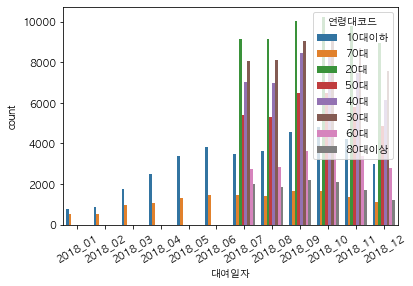

In [26]:
bike18 = bike18.sort_values(by='대여일자', ascending=True)
sns.countplot(x='대여일자',hue='연령대코드', data=bike18)
plt.xticks(rotation=30)

## 07) 2019년 2020년 20대의 총 이용건수 비교

In [27]:
# '2019년 20대의 총 이용건수'와 '2020년 20대의 총 이용건수'를 하나의 데이터 프레임으로 merge
bike_merge_sum_age02 = pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                               '19년 20대 총 이용건수' : bike19_sum_age02['총 이용건수'], 
                               '20년 20대 총 이용건수' : bike20_sum_age02['총 이용건수'],
                               '21년 20대 총 이용건수' : bike21_sum_age02['총 이용건수']})
bike_merge_sum_age02 = bike_merge_sum_age02.reset_index(drop=True)
bike_merge_sum_age02

,Month,19년 20대 총 이용건수,20년 20대 총 이용건수,21년 20대 총 이용건수
0,Jan,201802,326277,182609.0
1,Feb,201443,317169,267360.0
2,Mar,421777,704244,447523.0
3,Apr,716136,995677,608071.0
4,May,1100571,1164916,610881.0
5,Jun,1149248,1278029,698186.0
6,Jul,1068924,1184603,NaN
7,Aug,1041427,786812,NaN
8,Sep,1022525,1302676,NaN
9,Oct,1151041,1286939,NaN


In [28]:
bike_merge_sum_age02.iplot(kind='line',x='Month',theme='space',title="20대의 월별 총 이용건수 연간 비교", xTitle="월", yTitle="20대의 총 이용건수")

## 08) 2019년 2020년 20대 총 이용시간 비교

In [29]:
# '2019년 20대의 총 이용시간'과 '2020년 20대의 총 이용시간'을 하나의 데이터 프레임으로 merge
bike_merge_sum2_age02 = pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                            '19년 20대 총 이용시간' : bike19_sum_age02['총 이용시간'], 
                            '20년 20대 총 이용시간' : bike20_sum_age02['총 이용시간'],
                            '21년 20대 총 이용시간' : bike21_sum_age02['총 이용시간']})
bike_merge_sum2_age02 = bike_merge_sum2_age02.reset_index(drop=True)
bike_merge_sum2_age02

,Month,19년 20대 총 이용시간,20년 20대 총 이용시간,21년 20대 총 이용시간
0,Jan,3679159,6177108,4677822.0
1,Feb,4330084,6915634,7787758.0
2,Mar,9567755,24050027,11995223.0
3,Apr,19310374,33203710,17324014.0
4,May,31170857,39021659,17078800.0
5,Jun,29915544,37861731,18050900.0
6,Jul,25890616,34969389,NaN
7,Aug,27113493,21358964,NaN
8,Sep,27646405,43697421,NaN
9,Oct,28418262,35566570,NaN


In [30]:
bike_merge_sum2_age02.iplot(kind='line',x='Month',theme='space',title="20대의 월별 총 이용시간 연간 비교", xTitle="월", yTitle="20대의 총 이용시간(분)")

## 09) 2019년 2020년 20대 총 이동거리비교

In [31]:
# '2019년 20대의 총 이동거리'과 '2020년 20대의 총 이동거리'을 하나의 데이터 프레임으로 merge
bike_merge_sum3_age02 = pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                            '19년 20대 총 이동거리' : bike19_sum_age02['총 이동거리'], 
                            '20년 20대 총 이동거리' : bike20_sum_age02['총 이동거리']})
bike_merge_sum3_age02 = bike_merge_sum3_age02.reset_index(drop=True)
bike_merge_sum3_age02

,Month,19년 20대 총 이동거리,20년 20대 총 이동거리
0,Jan,691614820,1.306170e+09
1,Feb,788315740,1.398153e+09
2,Mar,1718188060,4.180080e+09
3,Apr,3243287552,4.580501e+09
4,May,5467285170,4.420488e+09
5,Jun,5988014700,8.333574e+09
6,Jul,5510300840,2.998039e+09
7,Aug,5443505970,5.503126e+08
8,Sep,5630820630,1.114244e+09
9,Oct,6161908800,5.501886e+08


In [32]:
bike_merge_sum3_age02.iplot(kind='line',x='Month',theme='space')

## 10) 2019년 2020년 20대 한 사람의 평균 이용건수 비교

In [33]:
# '2019년 20대의 한사람의 평균 이용건수'과 '2020년 20대의 한사람의 평균 이용건수'을 하나의 데이터 프레임으로 merge
bike_merge_mean_age02 = pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                            '19년 20대 한 사람 평균 이용건수' : bike19_mean_age02['평균 이용건수'], 
                            '20년 20대 한 사람 평균 이용건수' : bike20_mean_age02['평균 이용건수'],
                            '21년 20대 한 사람 평균 이용건수' : bike21_mean_age02['평균 이용건수']})
bike_merge_mean_age02 = bike_merge_mean_age02.reset_index(drop=True)
bike_merge_mean_age02

,Month,19년 20대 한 사람 평균 이용건수,20년 20대 한 사람 평균 이용건수,21년 20대 한 사람 평균 이용건수
0,Jan,22.449883,26.520117,11.552413
1,Feb,21.368728,25.274444,14.168521
2,Mar,41.161023,49.504007,22.151314
3,Apr,64.262024,67.867017,26.251824
4,May,94.122210,73.878488,25.557736
5,Jun,76.764946,70.136593,28.430084
6,Jul,72.493998,64.140073,NaN
7,Aug,70.686690,44.945276,NaN
8,Sep,69.697021,68.953843,NaN
9,Oct,79.623755,69.365547,NaN


In [34]:
bike_merge_mean_age02.iplot(kind='line',x='Month',theme='space',title="20대의 월별 한 사람 평균 이용건수 연간 비교", xTitle="월", yTitle="20대의 한 사람 평균 이용건수")

## 11) 2019년 2020년 20대 한 사람의 평균 이용시간 비교

In [35]:
# '2019년 20대의 한사람의 평균 이용시간'과 '2020년 20대의 한사람의 평균 이용시간'을 하나의 데이터 프레임으로 merge
bike_merge_mean2_age02 = pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                            '19년 20대 한 사람 평균 이용시간' : bike19_mean_age02['평균 이용시간'], 
                            '20년 20대 한 사람 평균 이용시간' : bike20_mean_age02['평균 이용시간'],
                            '21년 20대 한 사람 평균 이용시간' : bike21_mean_age02['평균 이용시간']})
bike_merge_mean2_age02 = bike_merge_mean2_age02.reset_index(drop=True)
bike_merge_mean2_age02

,Month,19년 20대 한 사람 평균 이용시간,20년 20대 한 사람 평균 이용시간,21년 20대 한 사람 평균 이용시간
0,Jan,409.295695,502.081444,295.933574
1,Feb,459.327888,551.090445,412.705776
2,Mar,933.712794,1690.568466,593.734742
3,Apr,1732.804559,2263.220639,747.917541
4,May,2665.770718,2474.737380,714.534349
5,Jun,1998.232850,2077.803260,735.031354
6,Jul,1755.891217,1893.409984,NaN
7,Aug,1840.323967,1220.093911,NaN
8,Sep,1884.425397,2313.011910,NaN
9,Oct,1965.845462,1917.025279,NaN


In [36]:
bike_merge_mean_age02.iplot(kind='line',x='Month',theme='space',title="20대의 월별 한 사람 평균 이용시간 연간 비교", xTitle="월", yTitle="20대의 한 사람 평균 이용시간")

## 12) 2019년 2020년 20대 한 사람의 평균 이동거리 비교

In [37]:
# '2019년 20대의 한사람의 평균 이동거리'과 '2020년 20대의 한사람의 평균 이동거리'을 하나의 데이터 프레임으로 merge
bike_merge_mean3_age02 = pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                            '19년 20대 한 사람 평균 이동거리' : bike19_mean_age02['평균 이동거리'], 
                            '20년 20대 한 사람 평균 이동거리' : bike20_mean_age02['평균 이동거리'],
                            '21년 20대 한 사람 평균 이동거리' : bike21_mean_age02['평균 이동거리']})
bike_merge_mean3_age02 = bike_merge_mean3_age02.reset_index(drop=True)
bike_merge_mean3_age02

,Month,19년 20대 한 사람 평균 이동거리,20년 20대 한 사람 평균 이동거리,21년 20대 한 사람 평균 이동거리
0,Jan,76940.129047,106166.820288,32193.129193
1,Feb,83623.182349,111415.477727,47504.882275
2,Mar,167677.179662,293833.808754,69006.725383
3,Apr,291034.417803,312214.652035,85008.941021
4,May,467569.072950,280345.499120,82762.622868
5,Jun,399974.263576,457335.855945,86264.229914
6,Jul,373706.398101,162328.177596,NaN
7,Aug,369477.090206,31435.658333,NaN
8,Sep,383806.191125,58979.669817,NaN
9,Oct,426252.684007,29654.969430,NaN


In [38]:
bike_merge_mean3_age02.iplot(kind='line',x='Month',theme='space',title="20대의 월별 한 사람 평균 이동거리 연간 비교", xTitle="월", yTitle="20대의 한 사람 평균 이동거리")

## 13) 2019년 2020년 20대 한 사람의 평균 주행속력 비교

In [39]:
# '2019년 20대의 한사람의 평균 주행속력'과 '2020년 20대의 한사람의 평균 주행속력'을 하나의 데이터 프레임으로 merge
bike_merge_mean4_age02 = pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                            '19년 20대 한 사람 평균 주행속력' : bike19_mean_age02['평균 주행속력'], 
                            '20년 20대 한 사람 평균 주행속력' : bike20_mean_age02['평균 주행속력'],
                            '21년 20대 한 사람 평균 주행속력' : bike21_mean_age02['평균 주행속력']})
bike_merge_mean4_age02 = bike_merge_mean4_age02.reset_index(drop=True)
bike_merge_mean4_age02

,Month,19년 20대 한 사람 평균 주행속력,20년 20대 한 사람 평균 주행속력,21년 20대 한 사람 평균 주행속력
0,Jan,13.066209,13.419372,6.691908
1,Feb,11.583223,12.848209,7.102262
2,Mar,11.298554,11.387444,6.902837
3,Apr,10.294392,8.902060,6.765084
4,May,10.721522,7.565749,6.914267
5,Jun,11.960381,13.823240,7.071820
6,Jul,12.728430,4.975151,NaN
7,Aug,12.198673,1.578806,NaN
8,Sep,12.523935,1.553640,NaN
9,Oct,13.763132,1.029069,NaN


In [40]:
bike_merge_mean4_age02.iplot(kind='line',x='Month',theme='space',title="20대의 월별 한 사람 평균 주행속력 연간 비교", xTitle="월", yTitle="20대의 한 사람 평균 주행속력")

## 14) 2019년 2020년 30대의 총 이용건수 비교

In [41]:
# '2019년 30대의 총 이용건수'와 '2020년 30대의 총 이용건수'를 하나의 데이터 프레임으로 merge
bike_merge_sum_age03 = pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                               '19년_30대 총 이용건수' : bike19_sum_age03['총 이용건수'], 
                               '20년_30대 총 이용건수' : bike20_sum_age03['총 이용건수'],
                               '21년_30대 총 이용건수' : bike21_sum_age03['총 이용건수']})
bike_merge_sum_age03 = bike_merge_sum_age03.reset_index(drop=True)

bike_merge_sum_age03.iplot(kind='line',x='Month',theme='space')

# 연령대별 분류 + 연도별 분류 + 월별 분류
## -> '어느 나이대 구간'이 '따릉이 이용'에 있어서 코로나 영향을 가장 많이 받았는가?

## 15) 2019년 2020년 20대의 총 이용건수 증감비율

In [42]:
bike_ratio_sum_age02 = pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                               '19년 총 이용건수' : bike19_sum_age02['총 이용건수'], 
                               '20년 총 이용건수' : bike20_sum_age02['총 이용건수'],
                               '21년 총 이용건수' : bike21_sum_age02['총 이용건수']})
bike_ratio_sum_age02 = bike_ratio_sum_age02.reset_index(drop=True)
bike_ratio_sum_age02

,Month,19년 총 이용건수,20년 총 이용건수,21년 총 이용건수
0,Jan,201802,326277,182609.0
1,Feb,201443,317169,267360.0
2,Mar,421777,704244,447523.0
3,Apr,716136,995677,608071.0
4,May,1100571,1164916,610881.0
5,Jun,1149248,1278029,698186.0
6,Jul,1068924,1184603,NaN
7,Aug,1041427,786812,NaN
8,Sep,1022525,1302676,NaN
9,Oct,1151041,1286939,NaN


In [43]:
bike_ratio_sum_age02['19년vs20년'] = ( bike_ratio_sum_age02['20년 총 이용건수']- bike_ratio_sum_age02['19년 총 이용건수']) / bike_ratio_sum_age02['19년 총 이용건수'] * 100
bike_ratio_sum_age02['20년vs21년'] = ( bike_ratio_sum_age02['21년 총 이용건수']- bike_ratio_sum_age02['20년 총 이용건수']) / bike_ratio_sum_age02['20년 총 이용건수'] * 100

bike_ratio_sum_age02.head()

,Month,19년 총 이용건수,20년 총 이용건수,21년 총 이용건수,19년vs20년,20년vs21년
0,Jan,201802,326277,182609.0,61.681747,-44.032525
1,Feb,201443,317169,267360.0,57.448509,-15.704246
2,Mar,421777,704244,447523.0,66.970698,-36.453417
3,Apr,716136,995677,608071.0,39.034625,-38.928890
4,May,1100571,1164916,610881.0,5.846511,-47.560082


In [44]:
bike_ratio_sum_age02 = bike_ratio_sum_age02.drop(['19년 총 이용건수','20년 총 이용건수','21년 총 이용건수'],axis=1)
bike_ratio_sum_age02.head()

,Month,19년vs20년,20년vs21년
0,Jan,61.681747,-44.032525
1,Feb,57.448509,-15.704246
2,Mar,66.970698,-36.453417
3,Apr,39.034625,-38.928890
4,May,5.846511,-47.560082


In [45]:
#bike_ratio_sum_age02.iloc[:,[0,2]].iplot(kind='line',x='Month',theme='space')
bike_ratio_sum_age02.iplot(kind='line',x='Month',theme='space',title="2019년 2020년 20대의 총 이용건수 증감비율", xTitle="월", yTitle="작년 대비 20대의 총 이용건수 증감 비율(%)")

## 16) 2019년 2020년 30대의 총 이용건수 증감비율

In [46]:
bike_ratio_sum_age03 = pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                               '19년 총 이용건수' : bike19_sum_age03['총 이용건수'], 
                               '20년 총 이용건수' : bike20_sum_age03['총 이용건수'],
                               '21년 총 이용건수' : bike21_sum_age03['총 이용건수']})
bike_ratio_sum_age03 = bike_ratio_sum_age03.reset_index(drop=True)
bike_ratio_sum_age03

,Month,19년 총 이용건수,20년 총 이용건수,21년 총 이용건수
0,Jan,126778,187520,197968.0
1,Feb,115852,176534,294533.0
2,Mar,212208,333664,520888.0
3,Apr,344435,485148,710608.0
4,May,478704,559575,648726.0
5,Jun,514313,642052,746743.0
6,Jul,468794,576365,NaN
7,Aug,449651,383188,NaN
8,Sep,447686,623389,NaN
9,Oct,528647,647601,NaN


In [47]:
bike_ratio_sum_age03['19년vs20년'] = ( bike_ratio_sum_age03['20년 총 이용건수']- bike_ratio_sum_age03['19년 총 이용건수']) / bike_ratio_sum_age03['19년 총 이용건수'] * 100
bike_ratio_sum_age03['20년vs21년'] = ( bike_ratio_sum_age03['21년 총 이용건수']- bike_ratio_sum_age03['20년 총 이용건수']) / bike_ratio_sum_age03['20년 총 이용건수'] * 100

bike_ratio_sum_age03.head()

,Month,19년 총 이용건수,20년 총 이용건수,21년 총 이용건수,19년vs20년,20년vs21년
0,Jan,126778,187520,197968.0,47.912098,5.571672
1,Feb,115852,176534,294533.0,52.378897,66.842081
2,Mar,212208,333664,520888.0,57.234412,56.111537
3,Apr,344435,485148,710608.0,40.853281,46.472417
4,May,478704,559575,648726.0,16.893738,15.931913


In [48]:
bike_ratio_sum_age03 = bike_ratio_sum_age03.drop(['19년 총 이용건수','20년 총 이용건수','21년 총 이용건수'],axis=1)
bike_ratio_sum_age03.head()

,Month,19년vs20년,20년vs21년
0,Jan,47.912098,5.571672
1,Feb,52.378897,66.842081
2,Mar,57.234412,56.111537
3,Apr,40.853281,46.472417
4,May,16.893738,15.931913


In [49]:
bike_ratio_sum_age03.iplot(kind='line',x='Month',theme='space',title="2019년 2020년 30대의 총 이용건수 증감비율", xTitle="월", yTitle="작년 대비 20대의 총 이용건수 증감 비율(%)")

## 17) 2019년 2020년, 20대와 30대의 총 이용건수 증감비율 비교

In [50]:
bike_ratio_sum_age02vs03 =  pd.DataFrame({'Month'   : ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                               '19년vs20년 20대의 증감비율' : bike_ratio_sum_age02['19년vs20년'], 
                               '19년vs20년 30대의 증감비율' : bike_ratio_sum_age03['19년vs20년']
                              # ,'20년vs21년 20대의 증감비율' : bike_ratio_sum_age02['20년vs21년']
                              # ,'20년vs21년 30대의 증감비율' : bike_ratio_sum_age03['20년vs21년']
                                         })
bike_ratio_sum_age02vs03

,Month,19년vs20년 20대의 증감비율,19년vs20년 30대의 증감비율
0,Jan,61.681747,47.912098
1,Feb,57.448509,52.378897
2,Mar,66.970698,57.234412
3,Apr,39.034625,40.853281
4,May,5.846511,16.893738
5,Jun,11.205675,24.836821
6,Jul,10.822004,22.946326
7,Aug,-24.448665,-14.781019
8,Sep,27.397961,39.246928
9,Oct,11.806530,22.501594


In [51]:
bike_ratio_sum_age02vs03.iplot(kind='line',x='Month',theme='space',title="전년대비 이용건수 증감비율 연령대 비교", xTitle="월", yTitle="작년 대비 총 이용건수 증감 비율(%)")